# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

-0.3326417651384787
3.4846969393878777 -0.3364120605217679
3.4886977395479097 -0.3401769711655881
3.4926985397079418 -0.34393643680734654
3.4966993398679738 -0.34769039727160556
3.500700140028006 -0.35143879247104526
3.504700940188038 -0.35518156240742554
3.50870174034807 -0.35891864717254646
3.512702540508102 -0.362649986949207
3.516703340668134 -0.3663755220121628
3.520704140828166 -0.3700951927290816
3.524704940988198 -0.3738089395614984
3.5287057411482294 -0.3775167030657677
3.5327065413082614 -0.3812184238940165
3.5367073414682935 -0.38491404279509217
3.5407081416283255 -0.3886035006155121
3.5447089417883575 -0.3922867383004102
3.5487097419483895 -0.3959636968944826
3.5527105421084215 -0.39963431754293044
3.5567113422684535 -0.40329854149240285
3.5607121424284855 -0.4069563100919367
3.5647129425885176 -0.41060756479389593
3.5687137427485496 -0.41425224715490805
3.5727145429085816 -0.4178902988368001
3.5767153430686136 -0.4215216616075325
3.5807161432286456 -0.4251462773421307
3.58

0.6991630291318807
7.061412282456491 0.7020178471617724
7.065413082616523 0.7048614284268354
7.069413882776555 0.7076937274116258
7.073414682936587 0.7105146987812883
7.077415483096619 0.7133242973822813
7.081416283256651 0.7161224782431006
7.085417083416683 0.7189091965749983
7.089417883576715 0.7216844077727003
7.093418683736747 0.7244480674151198
7.097419483896779 0.7272001312660691
7.101420284056811 0.7299405552749667
7.105421084216843 0.732669295577543
7.109421884376875 0.7353863084965423
7.113422684536907 0.7380915505424217
7.117423484696939 0.7407849784140476
7.121424284856971 0.7434665489993882
7.125425085017003 0.7461362193762046
7.129425885177035 0.7487939468127364
7.133426685337067 0.7514396887683868
7.137427485497099 0.7540734028944035
7.141428285657131 0.7566950470345556
7.145429085817163 0.7593045792258093
7.149429885977195 0.7619019576989993
7.153430686137227 0.7644871408794972
7.157431486297259 0.7670600873878773
7.161432286457291 0.7696207560405786
7.165433086617323 0.

-0.7963832236912474
10.350070014002801 -0.7987964968757905
10.354070814162833 -0.8011969842196064
10.358071614322865 -0.8035846472995813
10.362072414482897 -0.8059594478978713
10.36607321464293 -0.8083213480025142
10.370074014802961 -0.8106703098080379
10.374074814962993 -0.813006295716066
10.378075615123025 -0.8153292683359189
10.382076415283057 -0.8176391904852129
10.38607721544309 -0.8199360251904549
10.390078015603121 -0.8222197356876346
10.394078815763153 -0.8244902854228127
10.398079615923185 -0.8267476380527059
10.402080416083217 -0.828991757445269
10.40608121624325 -0.8312226076802729
10.410082016403281 -0.8334401530498797
10.414082816563313 -0.8356443580592146
10.418083616723345 -0.837835187426933
10.422084416883378 -0.8400126060857863
10.42608521704341 -0.8421765791831831
10.430086017203442 -0.8443270720817462
10.434086817363474 -0.8464640503598678
10.438087617523506 -0.8485874798122605
10.442088417683538 -0.8506973264505043
10.44608921784357 -0.8527935565035909
10.4500900180

13.626725345069014 0.8725288453960336
13.630726145229046 0.8744764984947787
13.634726945389078 0.8764101543898893
13.63872774554911 0.8783297821305333
13.642728545709142 0.8802353509904183
13.646729345869174 0.8821268304682842
13.650730146029206 0.8840041902883904
13.654730946189238 0.8858674004010013
13.65873174634927 0.8877164309828668
13.662732546509302 0.8895512524376996
13.666733346669334 0.8913718353966493
13.670734146829366 0.8931781507187722
13.674734946989398 0.8949701694914977
13.67873574714943 0.8967478630310913
13.682736547309462 0.8985112028831139
13.686737347469494 0.9002601608228767
13.690738147629526 0.9019947088558932
13.694738947789558 0.9037148192183275
13.69873974794959 0.9054204643774386
13.702740548109622 0.9071116170320209
13.706741348269654 0.9087882501128414
13.710742148429686 0.9104503367830729
13.714742948589718 0.9120978504387237
13.71874374874975 0.9137307647090631
13.722744548909782 0.9153490534570441
13.726745349069814 0.9169526907797209
13.73074614922984

16.855371074214844 -0.9117019962191544
16.859371874374876 -0.913338432564167
16.863372674534908 -0.9149602496666387
16.86737347469494 -0.9165674215671478
16.871374274854972 -0.918159922540689
16.875375075015004 -0.9197377270970859
16.879375875175036 -0.9213008099813982
16.883376675335068 -0.9228491461743262
16.8873774754951 -0.9243827108926119
16.891378275655132 -0.9259014795894346
16.895379075815164 -0.9274054279548045
16.899379875975196 -0.9288945319159518
16.903380676135228 -0.9303687676377118
16.90738147629526 -0.9318281115229063
16.911382276455292 -0.933272540212722
16.915383076615324 -0.9347020305870833
16.919383876775356 -0.9361165597650235
16.923384676935388 -0.93751610510505
16.92738547709542 -0.9389006442055076
16.931386277255452 -0.9402701549049365
16.935387077415484 -0.9416246152824274
16.939387877575516 -0.9429640036579717
16.94338867773555 -0.9442882985928096
16.94738947789558 -0.9455974788897724
16.951390278055612 -0.9468915235936218
16.955391078215644 -0.948170411991386

19.77995599119824 0.8018590519631835
19.78395679135827 0.8042431591840624
19.787957591518303 0.8066143933828646
19.791958391678335 0.8089727166047128
19.795959191838367 0.8113180911013882
19.7999599919984 0.8136504793319341
19.80396079215843 0.8159698439632568
19.807961592318463 0.8182761478707231
19.811962392478495 0.8205693541387553
19.815963192638527 0.822849426061421
19.81996399279856 0.8251163271430211
19.82396479295859 0.8273700210986744
19.827965593118623 0.8296104718548978
19.831966393278655 0.8318376435501836
19.835967193438687 0.8340515005355742
19.83996799359872 0.8362520073752322
19.84396879375875 0.8384391288470077
19.847969593918783 0.8406128299430019
19.851970394078815 0.842773075870128
19.855971194238847 0.8449198320506673
19.85997199439888 0.8470530641228237
19.86397279455891 0.8491727379412726
19.867973594718944 0.8512788195777083
19.871974394878976 0.8533712753213866
19.875975195039008 0.8554500716796644
19.87997599519904 0.8575151753785362
19.88397679535907 0.859566

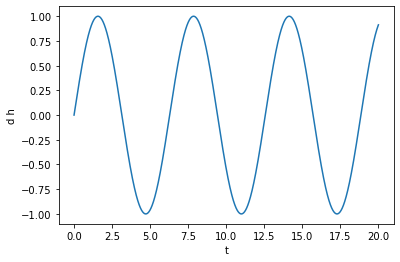

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

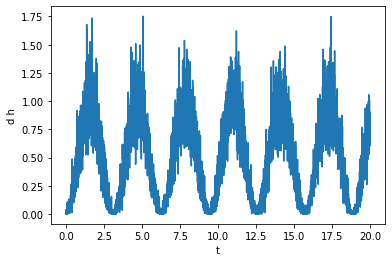

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

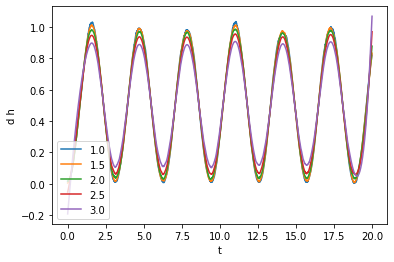

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

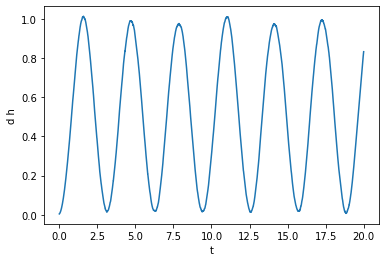

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1416


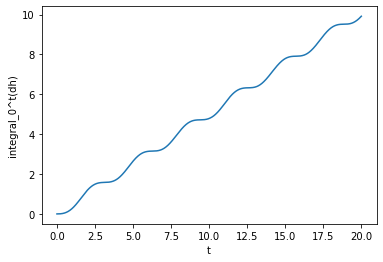

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

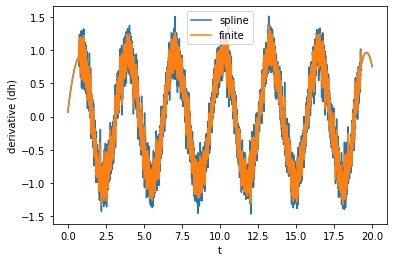

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

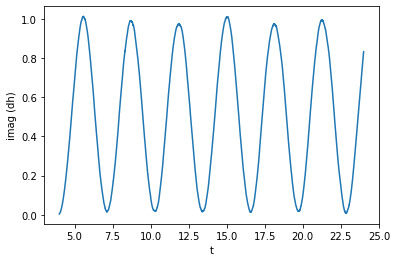

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

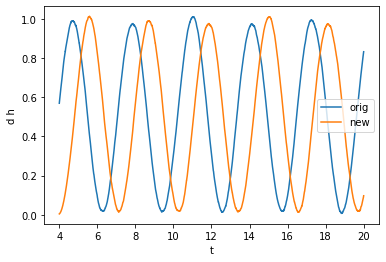

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

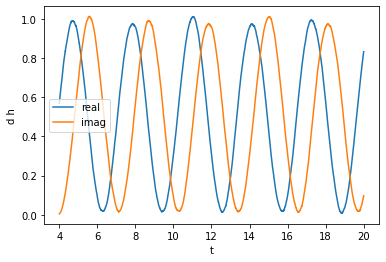

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

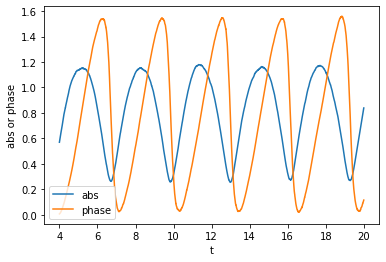

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

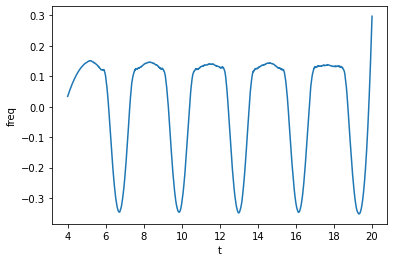

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

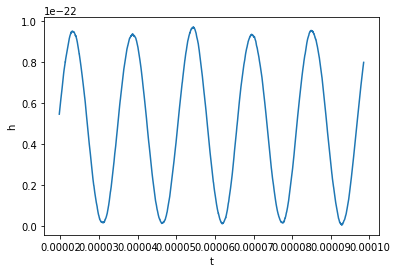

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

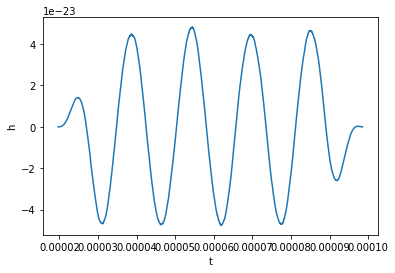

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

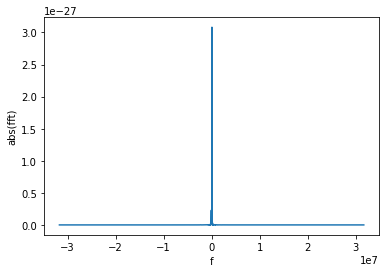

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

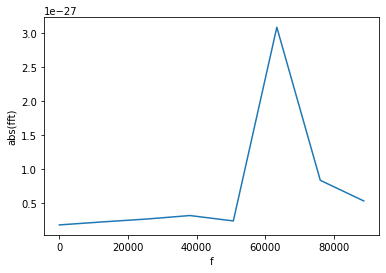

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64174.77


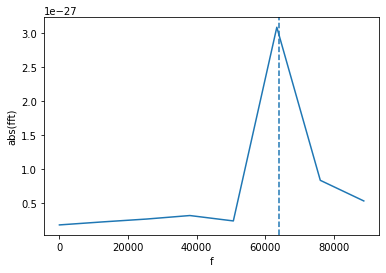

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.081e-27
Maximum with mask 8.297e-28
Length with mask 8
Length after having removed the masked points 7
